<a href="https://colab.research.google.com/github/KKOUWE/NumMet-Network-Design-Physarum-polycephalum-Ph/blob/main/Weigthed_Map_v2.03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 81.3 MB/s eta 0:00:00


Adding Weights to each food source

The nodes containing food are: {(39, 26): 0.2199, (12, 37): 0.0884, (24, 35): 0.0155, (13, 23): 0.0501, (14, 44): 0.0348, (31, 12): 0.0324, (13, 32): 0.03, (38, 45): 0.0292, (19, 16): 0.0265, (48, 29): 0.0238, (35, 12): 0.0224, (42, 32): 0.0184, (11, 39): 0.0182, (22, 33): 0.0177, (42, 19): 0.0171, (21, 39): 0.0161, (32, 36): 0.016, (33, 16): 0.0158, (14, 33): 0.0151, (24, 29): 0.015, (13, 37): 0.0147, (35, 18): 0.0146, (37, 1): 0.0142, (32, 20): 0.0139, (45, 26): 0.0137, (24, 22): 0.0133, (24, 40): 0.0133, (39, 25): 0.0123, (9, 28): 0.0121, (41, 40): 0.012, (31, 39): 0.012, (35, 25): 0.0118, (42, 22): 0.0114, (40, 26): 0.0113, (39, 40): 0.0107, (41, 17): 0.0108, (34, 44): 0.011}
The source node is: (24, 40) and the sink node is: (39, 26)


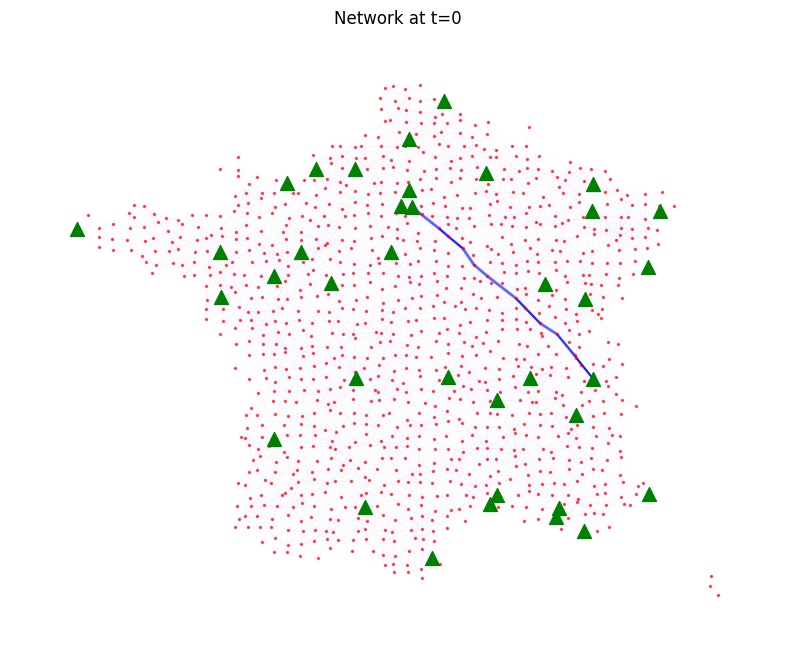

The source node is: (38, 45) and the sink node is: (21, 39)
The source node is: (33, 16) and the sink node is: (14, 33)


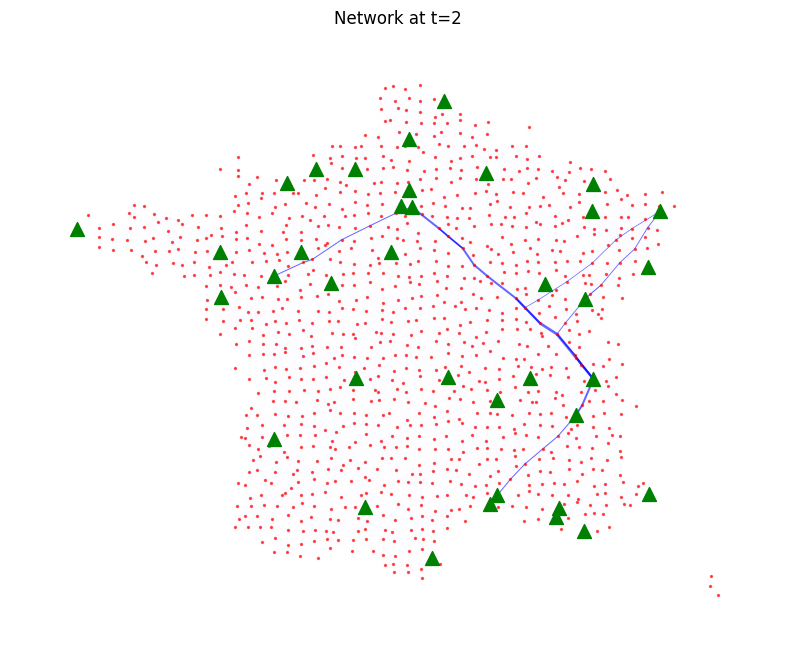

The source node is: (42, 22) and the sink node is: (45, 26)
The source node is: (22, 33) and the sink node is: (14, 33)


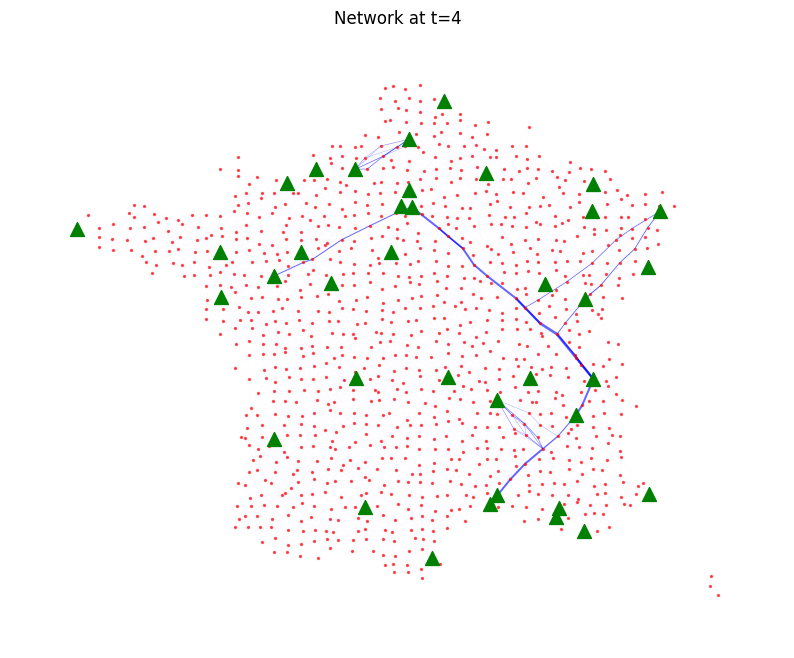

The source node is: (45, 26) and the sink node is: (12, 37)
The source node is: (14, 44) and the sink node is: (22, 33)


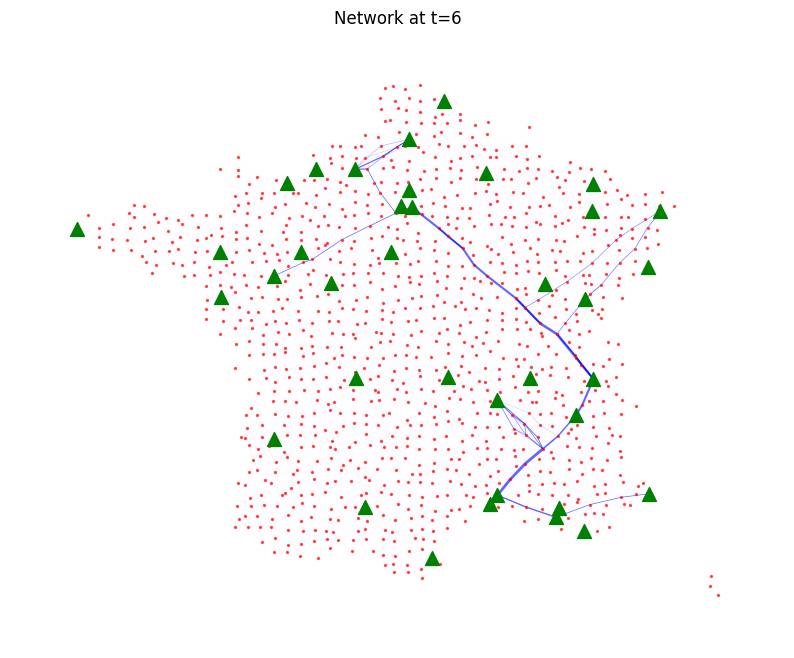

The source node is: (13, 32) and the sink node is: (14, 44)
The source node is: (12, 37) and the sink node is: (39, 26)


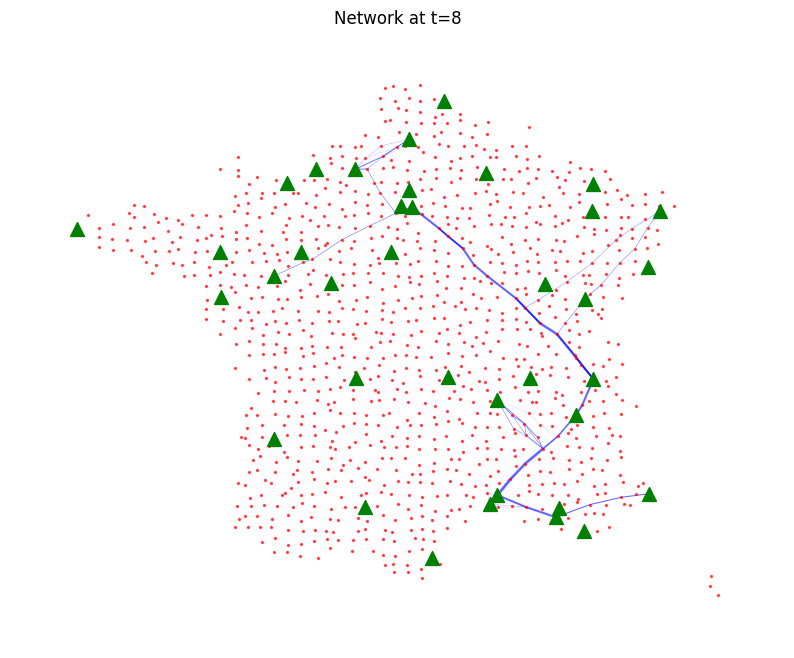

The source node is: (39, 26) and the sink node is: (42, 22)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Corrected import alias from 'panda' to 'pd'
import networkx as nx
import plotly.graph_objects as go
import random
from itertools import islice

# === ADD: Import additional libraries for geographic checks ===
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
# === End ADD ===

## This file has to be able to add a stochastic array of points over a given map,
## together with food sources (FS)

# Create an empty graph
G = nx.Graph()

# Define the grid dimensions and constants

# === ADD: Initial Parameters changed to get a more realistic outcome ===
rows, cols = 50, 50

k = 4
dx = 20.0  # For example, 20 km per grid cell
min_distance = 2 * np.sqrt(2) * dx + 0.1 * dx
total_width_km = cols * dx
total_height_km = rows * dx
# === End ADD ===


r = 1E-3                            # starting radius for all tubes
mu = 8.9E-4                         # dynamic viscocity of water (not 1 but yk)
pos_dict = {}                       # posistion dictionary for every node
sd = 0.2                            # standard deviation
I_0 = 3                           # Normalized flow/current
k = 10                               # number of paths
gamma = 1.15                        # constant that determines non linearity of radius response to flow. Present in dRdt function.
t = 0                               # timestep initialisation

# === ADD: Initial Parameters changed to get a more realistic outcome ===
dR = (np.pi * r / 8 * mu) * 0.01      # Reduction of radius term. Present in dRdt function
# === End ADD ===

t = 0                                 # Timestep initialization
convergence = False                   # Convergence init.

# === FIX: Define the geographic bounds for France and load its geometry ===
lon_min, lon_max = -5, 9
lat_min, lat_max = 41, 51

# Load France's shapefile
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

france_geom = None
for country in shpreader.Reader(shpfilename).records():
    if country.attributes['ADMIN'] == 'France':
        france_geom = country.geometry
        break

if france_geom is None:
    raise ValueError("France's geometry could not be found in the shapefile.")
# === End FIX ===

# Add nodes in a grid, ensuring they are within France's borders
for i in range(rows):
    for j in range(cols):
        # Assign positions in kilometers, starting at (0,0) for the bottom-left corner
        # Add a small Gaussian noise in km to randomize positions slightly
        x_km = j * dx + np.random.normal(loc=0, scale=sd * dx)
        y_km = i * dx + np.random.normal(loc=0, scale=sd * dx)

        # Map from km to lat/lon for the geographic check
        normalized_x = x_km / total_width_km    # Maps to [0,1] across France's longitudinal extent
        normalized_y = y_km / total_height_km   # Maps to [0,1] across France's latitudinal extent

        lon = lon_min + normalized_x * (lon_max - lon_min)
        lat = lat_min + normalized_y * (lat_max - lat_min)

        # Create a point for the geometry check
        point = Point(lon, lat)

        # Check if the point is inside France
        if france_geom.contains(point):
            # If inside, add the node with positions in kilometers
            pos_dict[(i, j)] = (x_km, y_km)
            G.add_node((i, j), pos=(x_km, y_km), FS=0)
        else:
            continue

        # === End FIX ===

# Retrieve the positions for all nodes
pos = nx.get_node_attributes(G, 'pos')

# === FIX: Iterate only over existing nodes to add edges ===
for node in G.nodes():
    for neighbor in G.nodes():
        if neighbor != node:
            pos_center = pos_dict[node]
            pos_nb = pos_dict[neighbor]
            pos_center_i = pos_center[0]
            pos_center_j = pos_center[1]
            pos_nb_i = pos_nb[0]
            pos_nb_j = pos_nb[1]
            # Calculate distance
            distance = np.sqrt((pos_center_i - pos_nb_i) ** 2 + (pos_center_j - pos_nb_j) ** 2)
            if distance < min_distance:
                G.add_edge(node, neighbor, length=distance, radius=r)
# === End FIX ===

# === ADD: Define Food Sources (FS) Based on Specific Cities ===

cities = {
    'Paris': {'lat': 48.8566, 'lon': 2.3522, 'normalized_population': 0.2199},
    'Marseille': {'lat': 43.2965, 'lon': 5.3698, 'normalized_population': 0.0884},
    'Lyon': {'lat': 45.7640, 'lon': 4.8357, 'normalized_population': 0.0531},
    'Toulouse': {'lat': 43.6047, 'lon': 1.4442, 'normalized_population': 0.0501},
    'Nice': {'lat': 43.7102, 'lon': 7.2620, 'normalized_population': 0.0348},
    'Nantes': {'lat': 47.2184, 'lon': -1.5536, 'normalized_population': 0.0324},
    'Montpellier': {'lat': 43.6108, 'lon': 3.8767, 'normalized_population': 0.0300},
    'Strasbourg': {'lat': 48.5734, 'lon': 7.7521, 'normalized_population': 0.0292},
    'Bordeaux': {'lat': 44.8378, 'lon': -0.5792, 'normalized_population': 0.0265},
    'Lille': {'lat': 50.6292, 'lon': 3.0573, 'normalized_population': 0.0238},
    'Rennes': {'lat': 48.1173, 'lon': -1.6778, 'normalized_population': 0.0224},
    'Reims': {'lat': 49.2583, 'lon': 4.0317, 'normalized_population': 0.0184},
    'Toulon': {'lat': 43.1242, 'lon': 5.9280, 'normalized_population': 0.0182},
    'Saint-Étienne': {'lat': 45.4397, 'lon': 4.3872, 'normalized_population': 0.0177},
    'Le Havre': {'lat': 49.4944, 'lon': 0.1079, 'normalized_population': 0.0171},
    'Grenoble': {'lat': 45.1885, 'lon': 5.7245, 'normalized_population': 0.0161},
    'Dijon': {'lat': 47.3220, 'lon': 5.0415, 'normalized_population': 0.0160},
    'Villeurbanne': {'lat': 45.7719, 'lon': 4.8902, 'normalized_population': 0.0155},
    'Angers': {'lat': 47.4784, 'lon': -0.5632, 'normalized_population': 0.0158},
    'Nîmes': {'lat': 43.8367, 'lon': 4.3601, 'normalized_population': 0.0151},
    'Clermont-Ferrand': {'lat': 45.7772, 'lon': 3.0870, 'normalized_population': 0.0150},
    'Aix-en-Provence': {'lat': 43.5297, 'lon': 5.4474, 'normalized_population': 0.0147},
    'Le Mans': {'lat': 48.0061, 'lon': 0.1996, 'normalized_population': 0.0146},
    'Brest': {'lat': 48.3904, 'lon': -4.4861, 'normalized_population': 0.0142},
    'Tours': {'lat': 47.3941, 'lon': 0.6848, 'normalized_population': 0.0139},
    'Amiens': {'lat': 49.8950, 'lon': 2.3023, 'normalized_population': 0.0137},
    'Limoges': {'lat': 45.8336, 'lon': 1.2611, 'normalized_population': 0.0133},
    'Annecy': {'lat': 45.8992, 'lon': 6.1296, 'normalized_population': 0.0133},
    'Boulogne-Billancourt': {'lat': 48.8397, 'lon': 2.2399, 'normalized_population': 0.0123},
    'Perpignan': {'lat': 42.6887, 'lon': 2.8948, 'normalized_population': 0.0121},
    'Metz': {'lat': 49.1193, 'lon': 6.1757, 'normalized_population': 0.0120},
    'Besançon': {'lat': 47.2378, 'lon': 6.0241, 'normalized_population': 0.0120},
    'Orléans': {'lat': 47.9029, 'lon': 1.9093, 'normalized_population': 0.0118},
    'Rouen': {'lat': 49.4432, 'lon': 1.0993, 'normalized_population': 0.0114},
    'Saint-Denis': {'lat': 48.9362, 'lon': 2.3574, 'normalized_population': 0.0115},
    'Nancy': {'lat': 48.6921, 'lon': 6.1844, 'normalized_population': 0.0107},
    'Caen': {'lat': 49.1829, 'lon': -0.3707, 'normalized_population': 0.0108},
    'Mulhouse': {'lat': 47.7508, 'lon': 7.3359, 'normalized_population': 0.0110},
    'Argenteuil': {'lat': 48.9472, 'lon': 2.2467, 'normalized_population': 0.0113}
}


def find_closest_node(pos_dict, target_pos):
    min_dist = float('inf')
    closest_node = None
    for node, (x, y) in pos_dict.items():
        dist = np.sqrt((x - target_pos[0])**2 + (y - target_pos[1])**2)
        if dist < min_dist:
            min_dist = dist
            closest_node = node
    return closest_node

FS = {}

for city, coords in cities.items():
    city_lon = coords['lon']
    city_lat = coords['lat']

    # NEW NEW NEW NEW
    x_km_city = (city_lon - lon_min) / (lon_max - lon_min) * total_width_km
    y_km_city = (city_lat - lat_min) / (lat_max - lat_min) * total_height_km


    closest_node = find_closest_node(pos_dict, (x_km_city, y_km_city))

    if closest_node:
        # Assign FS value and the normalized population
        FS[closest_node] = coords['normalized_population']

print(f"The nodes containing food are: {FS}")

# === End ADD ===

## ITERATION OF FLOW: parameters

def select_source_and_sink_nodes(FS):
    # Extract nodes and weights directly from FS
    nodes = list(FS.keys())
    weights = list(FS.values())

    # Select source and sink based on weights
    FS_source = random.choices(nodes, weights=weights, k=1)[0]
    FS_sink = random.choices(nodes, weights=weights, k=1)[0]

    # Ensure source and sink are not the same
    while FS_source == FS_sink:
        FS_sink = random.choices(nodes, weights=weights, k=1)[0]

    return [FS_source, FS_sink]

def Calc_Resistance_of_all_tubes():
    for u, v in G.edges():
        G[u][v]['resistance'] = (8 * (G[u][v]['length']) * mu) / (np.pi * (G[u][v]['radius'])**4)
    return

def k_shortest_paths(G, Nodes, k, weight='resistance'):
    try:
        paths_list = list(islice(nx.shortest_simple_paths(G, Nodes[0], Nodes[1], weight=weight), k))
        return paths_list
    except nx.NodeNotFound as e:
        print(f"Error finding paths: {e}")
        return []

def Resistance_of_paths(paths_list):
    resistance_of_paths_list = [
        sum((G[u][v]['resistance']) for u, v in zip(path, path[1:]))
        for path in paths_list
    ]
    return resistance_of_paths_list

def find_flow_distribution(resistance_of_paths_list):
    inverted_res_list = [(1/s) for s in resistance_of_paths_list if s != 0]
    Q = {}
    for i in range(0, k, 1):
        if i < len(inverted_res_list):
            total_inverse = sum(inverted_res_list) - inverted_res_list[i]
            if total_inverse != 0:
                total_resistance_i = 1 / total_inverse
            else:
                total_resistance_i = 0
            denominator = resistance_of_paths_list[i] + total_resistance_i
            if denominator != 0:
                Q[i] = (total_resistance_i / denominator) * I_0
            else:
                Q[i] = 0
    return Q

def find_flow_per_tube(list_of_paths, Q):
    flow_per_tube = {tuple(sorted(edge)): 0 for edge in G.edges()}
    a = 0
    for path in list_of_paths:
        for u, v in zip(path, path[1:]):
            flow_per_tube[tuple(sorted((u, v)))] += Q.get(a, 0)
        a += 1
    return flow_per_tube

def Adjust_radius(flow_per_tube):
    for u, v in G.edges():
        flow = flow_per_tube.get(tuple(sorted((u, v))), 0)
        G[u][v]['radius'] += 0.2 * ((flow)**gamma) / (1 + (flow)**gamma) - dR
        if G[u][v]['radius'] < 0:
            G[u][v]['radius'] = 0
    return

def Check_convergence(convergence, Q):
    for i in range(k):
        if Q.get(i, 0) > 0.99:
            convergence = True
            break
    return convergence

# Iteration loop
while not convergence:
    # 1. Select nodes
    Nodes = select_source_and_sink_nodes(FS)
    print(f"The source node is: {Nodes[0]} and the sink node is: {Nodes[1]}")

    # 2. Re-Calc resistance and Find paths
    Calc_Resistance_of_all_tubes()
    # Check if there's a path between the selected nodes
    if not nx.has_path(G, Nodes[0], Nodes[1]):
      print(f"No path found between {Nodes[0]} and {Nodes[1]}, selecting new nodes.")
      continue
    list_of_paths = k_shortest_paths(G, Nodes, k)


    if not list_of_paths:
        print("No paths found. Exiting the simulation loop.")
        break

    # 3. Calc resistance
    resistance_of_paths_list = Resistance_of_paths(list_of_paths)

    # 4. Divide flow
    Q = find_flow_distribution(resistance_of_paths_list)
    flow_per_tube = find_flow_per_tube(list_of_paths, Q)

    # 5. Adjust radius
    Adjust_radius(flow_per_tube)
    radius_list = [G[u][v]['radius'] for u, v in G.edges()]

    # === ADD: Plot after each 10 timesteps ===
    if t % 2 == 0:
        plt.figure(figsize=(10, 8))
        plt.title(f"Network at t={t}")
        max_r = max(radius_list) if radius_list else 1
        edge_opacity = [r / max_r for r in radius_list]
        edge_width = [(r / max_r) * 2 for r in radius_list]
        nx.draw(
            G,
            pos,
            with_labels=False,
            node_color='red',
            node_size=2,
            width=edge_width,
            edge_color='blue',
            alpha=0.6
        )
        # === ADD: Highlight Food Sources (FS) with a different shape/color ===
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=list(FS.keys()),
            node_color='green',
            node_shape='^',
            node_size=100
        )
        plt.show()
    # === END ADD ===

    t += 1
    convergence = Check_convergence(convergence, Q)


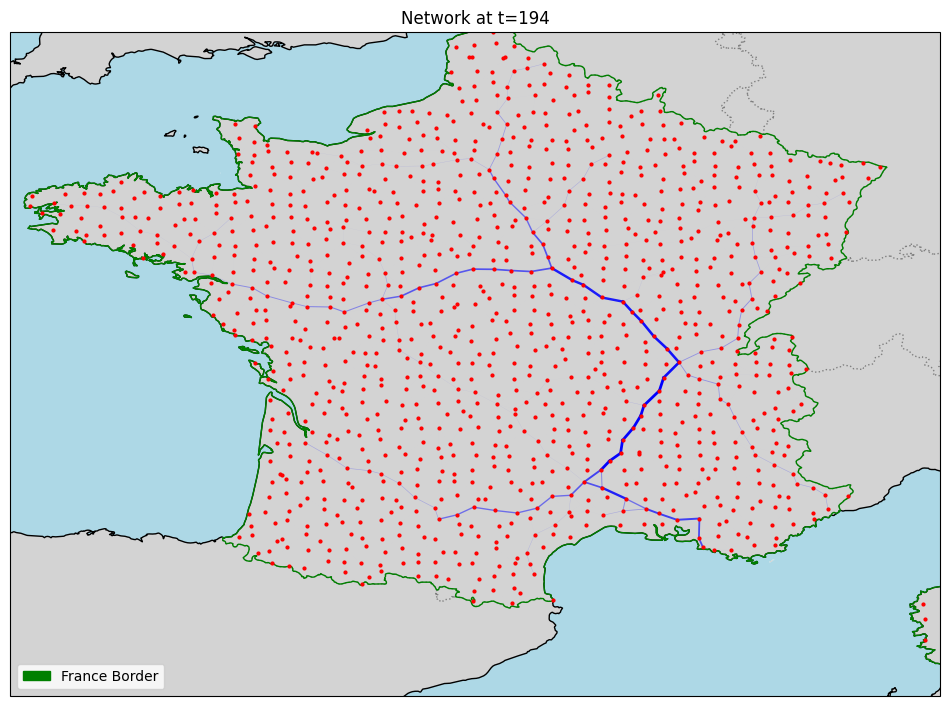

In [25]:
# --- Visualization Code ---

# Import necessary libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.io import shapereader
import matplotlib.patches as mpatches

# Use the same rows, cols as in the first code
# If the first part used rows, cols = 50, 50, do the same here
rows, cols = 50, 50

# Retrieve the positions for all nodes (already defined in the first part)
pos = nx.get_node_attributes(G, 'pos')

# Define the geographic bounds for France (should match the first part)
lon_min, lon_max = -5, 9
lat_min, lat_max = 41, 51

# Re-apply the same normalization and scaling that was used before
# In the first part, we did:
# normalized_pos_i = pos_i / cols
# normalized_pos_j = (pos_j + rows) / rows
# lon = lon_min + normalized_pos_i * (lon_max - lon_min)
# lat = lat_min + normalized_pos_j * (lat_max - lat_min)

scaled_pos = {}
for node, (pi, pj) in pos.items():
    normalized_pos_i = pi / cols
    normalized_pos_j = (pj + rows) / rows
    node_lon = lon_min + normalized_pos_i * (lon_max - lon_min)
    node_lat = lat_min + normalized_pos_j * (lat_max - lat_min)
    scaled_pos[node] = (node_lon, node_lat)

# Set up the map with Cartopy
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add standard map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')

# Highlight France's borders
shpfilename = shapereader.natural_earth(resolution='10m',
                                        category='cultural',
                                        name='admin_0_countries')

france_geom = None
for country in shapereader.Reader(shpfilename).records():
    if country.attributes['ADMIN'] == 'France':
        france_geom = country.geometry
        break

if france_geom:
    ax.add_geometries([france_geom],
                      crs=ccrs.PlateCarree(),
                      edgecolor='green',
                      facecolor='none',
                      linewidth=1,
                      label='France Border')
    france_patch = mpatches.Patch(color='green', label='France Border')
    ax.legend(handles=[france_patch], loc='lower left')
else:
    print("France's geometry could not be found in the shapefile.")

# Normalize edge properties for visualization
radius_list = [G[u][v]['radius'] for u, v in G.edges()]
max_r = max(radius_list) if radius_list else 1  # Prevent division by zero
edge_opacity = [r / max_r for r in radius_list]
edge_width = [(r / max_r) * 2 for r in radius_list]

# Plot edges (scaled correctly on the geographic map)
for (u, v), opacity, width in zip(G.edges(), edge_opacity, edge_width):
    x = [scaled_pos[u][0], scaled_pos[v][0]]
    y = [scaled_pos[u][1], scaled_pos[v][1]]
    ax.plot(x, y, transform=ccrs.PlateCarree(), color='blue', alpha=opacity, linewidth=width)

# Plot nodes (scaled correctly on the geographic map)
for node, (lon, lat) in scaled_pos.items():
    ax.plot(lon, lat, transform=ccrs.PlateCarree(), color='red', marker='o', markersize=2)

plt.title(f"Network at t={t}")
plt.show()


# The MERGED CODE